# 1 - Import y instalación de Librerías

In [ ]:
!pip install langdetect

     |████████████████████████████████| 983kB 5.4MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.8-cp36-none-any.whl size=993193 sha256=9774300639f2c3846d39adbd5c3aa1611d80c70224948a45c0f0400782979e4f
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d40a60ea06e6d669e8e5012e6c8b947a57
Successfully built langdetect


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.gridspec import GridSpec
import plotly.offline as py
import plotly.express as px
import plotly.graph_objs as go
from wordcloud import WordCloud
from collections import Counter
from PIL import Image

# DataPrep
from langdetect import detect
from nltk.corpus import stopwords
import re
import nltk
nltk.download('stopwords')
nltk.download('rslp')

from nltk.stem import RSLPStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import joblib

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, roc_auc_score, plot_roc_curve
import lightgbm as lgb

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.


# 2 - Carga de Datos

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "drive/My Drive/reviews_yelp_nn.csv"
data = pd.read_csv(path, sep="\t", low_memory=False)

In [ ]:
df = data.copy()

# 3 - EDA

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3342958 entries, 0 to 3342957
Data columns (total 9 columns):
 #   Column       Dtype  
---  ------       -----  
 0   business_id  object 
 1   cool         object 
 2   date         object 
 3   funny        float64
 4   review_id    object 
 5   stars        float64
 6   text         object 
 7   useful       float64
 8   user_id      object 
dtypes: float64(3), object(6)
memory usage: 229.5+ MB


In [ ]:
df.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,EhGPj8iJDIdaHnWg9d5BgA,0,2016-04-20 14:30:53,0.0,uJRdHLz4XNmDK5pOkWbZNA,5.0,"Best Dim Sum in the city, their cart service i...",0.0,POETn3fQcZ8ngLAARCATSg
1,VPcFNI-6HICR5SJM--KjNA,5,2013-05-14 03:08:12,2.0,TlPh8jy8bt_TSGfjEw-pvA,5.0,How... HOW did I not head down here sooner? Fo...,7.0,oUK6Xs5dPPnP4whFeZExGg
2,ugdUuApH3pYXggW5qpbALg,0,2016-08-26 16:51:37,0.0,GmoBAVE1pTo0kjmeKrXmLQ,4.0,Carnitas were wonderful. First time there and ...,0.0,SiaSUNlKQK7f57WBPmyyNw
3,3fCxmmg8nHGaE5upJWQUrw,0,2016-03-24 17:23:19,0.0,ZHuM9P81zfuNuFZ5ThXNRg,5.0,Great staff who are always willing to help. I ...,0.0,PsH5Qi8R69WAlhNv8mXWRA
4,LAqbIi2TDn8BDvPB0nLVhQ,1,2012-10-25 15:02:48,0.0,-2Ce00mfWYP20yt7k6kARg,3.0,"This place is bigger, brighter, new so it's cl...",3.0,r-zUIQPaHzvIyL93wQaoiQ


##Nulos

In [ ]:
#Cantidad datos que está en blanco en cada columna
df.isnull().sum()

business_id     0
cool            3
date            5
funny           9
review_id       9
stars           9
text           10
useful         14
user_id        14
dtype: int64

Como la cantidad de nulos es muy pequeña, decidimos eliminar estos valores.

In [ ]:
df = df.dropna()

In [ ]:
df.isnull().sum()

business_id    0
cool           0
date           0
funny          0
review_id      0
stars          0
text           0
useful         0
user_id        0
dtype: int64

### Manejo variable

Esta etapa tiene como objetivo ajustar los tipos de datos en función de su entrada.

#### Date

In [ ]:
df['date'].dtype

dtype('O')

In [ ]:
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True, errors='coerce')

In [ ]:
df['date'].dtype

dtype('<M8[ns]')

#### Cool

In [ ]:
df['cool'].dtype

dtype('O')

In [ ]:
df['cool'].value_counts()

0      2507467
1       506036
2       156793
3        64639
4        33061
        ...   
192          1
506          1
135          1
118          1
-1           1
Name: cool, Length: 168, dtype: int64

In [ ]:
df['cool'] = df['cool'].astype(int)

In [ ]:
df['cool'].dtype

dtype('int64')

#### Funny

In [ ]:
df['funny'].dtype

dtype('float64')

In [ ]:
data['funny'].unique()

array([  0.,   2.,   1.,   3.,   4.,  18.,   7.,   6.,   5.,  15.,   9.,
         8.,  10.,  13.,  16.,  19.,  11.,  12.,  17.,  34.,  42.,  14.,
        26.,  52.,  24.,  21.,  28.,  23.,  38.,  25.,  50.,  22.,  29.,
        27.,  30.,  33.,  73.,  40.,  31., 131.,  20.,  60.,  46.,  59.,
        32., 106.,  39., 126., 122.,  36.,  35.,  93.,  48.,  53.,  41.,
        67.,  37., 140.,  47.,  94.,  49., 123.,  44.,  61.,  57.,  78.,
        64., 156.,  58.,  51.,  98., 114.,  80.,  92.,  43., 184., 125.,
        55.,  54., 109.,  66.,  45.,  85.,  71.,  79.,  83.,  90., 104.,
        62.,  68., 107., 155., 179.,  69., 135.,  74., 102., 176., 124.,
       203.,  56.,  91.,  81., 105., 108.,  97.,  76., 159., 157.,  87.,
        nan,  65., 145.,  75., 178.,  70.,  95., 187., 275.,  77., 161.,
       440.,  96.,  84., 185., 163.,  88., 171., 133., 132., 290., 103.,
        63., 166., 168., 286., 148., 144., 143., 970.,  86., 137., 169.,
       127., 247., 254., 121.,  72., 101., 523., 11

In [ ]:
df['funny']=df['funny'].astype(int)

In [ ]:
df['funny'].dtype

dtype('int64')

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



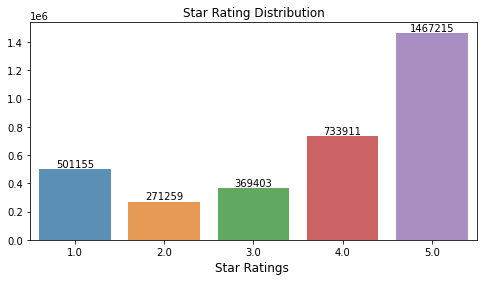

In [ ]:
# Vemos la distribution de 'rating' 
x=df['stars'].value_counts()
x=x.sort_index()

plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Star Rating Distribution")
plt.xlabel('Star Ratings ', fontsize=12)

rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

#### Tamaño del texto vs Stars

In [ ]:
df['length'] = df['text'].apply(len)
df.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id,length
0,EhGPj8iJDIdaHnWg9d5BgA,0,2016-04-20 14:30:53,0,uJRdHLz4XNmDK5pOkWbZNA,5.0,"Best Dim Sum in the city, their cart service i...",0.0,POETn3fQcZ8ngLAARCATSg,281
1,VPcFNI-6HICR5SJM--KjNA,5,2013-05-14 03:08:12,2,TlPh8jy8bt_TSGfjEw-pvA,5.0,How... HOW did I not head down here sooner? Fo...,7.0,oUK6Xs5dPPnP4whFeZExGg,1546
2,ugdUuApH3pYXggW5qpbALg,0,2016-08-26 16:51:37,0,GmoBAVE1pTo0kjmeKrXmLQ,4.0,Carnitas were wonderful. First time there and ...,0.0,SiaSUNlKQK7f57WBPmyyNw,206
3,3fCxmmg8nHGaE5upJWQUrw,0,2016-03-24 17:23:19,0,ZHuM9P81zfuNuFZ5ThXNRg,5.0,Great staff who are always willing to help. I ...,0.0,PsH5Qi8R69WAlhNv8mXWRA,275
4,LAqbIi2TDn8BDvPB0nLVhQ,1,2012-10-25 15:02:48,0,-2Ce00mfWYP20yt7k6kARg,3.0,"This place is bigger, brighter, new so it's cl...",3.0,r-zUIQPaHzvIyL93wQaoiQ,289


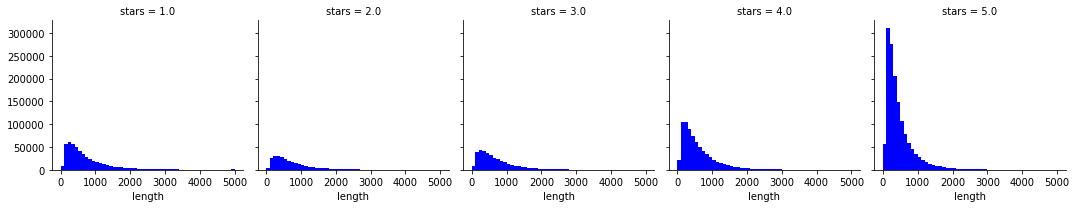

In [ ]:
# Comparar tamaño del texto con las estrellas
star_text = sns.FacetGrid(data=df,col='stars')
star_text.map(plt.hist,'length',bins=50,color='blue')

Los comentários con 5 estrellas son los que tienen mayor tamaño, seguidos de los comentários con 4 estrellas. Así, concluímos que las personas que dan los reviews considerados positivos escriben más en los comentários.

#### Correlación entre variables

In [ ]:
stars_val = df.groupby('stars').mean()
stars_val

,cool,funny,useful,length
stars,,,,
1.0,0.242548,0.613932,2.048470,759.886498
2.0,0.399131,0.622339,1.578410,763.426780
3.0,0.673438,0.610241,1.378180,710.374983
4.0,0.857391,0.568360,1.378671,623.374822
5.0,0.560054,0.334248,1.052409,481.391752


In [ ]:
# Correlation between vars
stars_val.corr()

,cool,funny,useful,length
cool,1.000000,-0.168688,-0.680801,-0.469497
funny,-0.168688,1.000000,0.713190,0.944867
useful,-0.680801,0.713190,1.000000,0.816325
length,-0.469497,0.944867,0.816325,1.000000


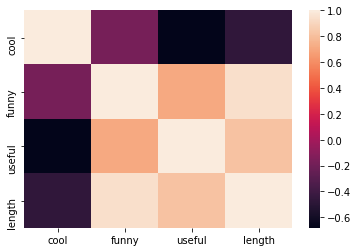

In [ ]:
sns.heatmap(stars_val.corr())

Identificamos que hay correlación negativa entre las variables:

* Cool and Useful
* Cool and Funny
* Cool and Length  

Hay correlación positiva entre las variables:

* Funny and Useful    
* Funny and Length
* Useful and Length    


In [ ]:
#sns.pairplot(df, vars = ["stars", "cool", "funny", "length"], hue ='stars')

### Definicón del target

Para definir el target asociaremos los reviews con 4 y 5 estrellas con un sentimiento positivo y los de 1 y 2 estrellas con un sentimiento negativo.

Entendemos que las reviews de 3 estrellas serían neutrales. Es muy probable que contengan ambos sentimientos.

Como nuestro objetivo es crear um modelo para reconocer el lenguaje positivo y negativo, decidimos no utilizar las calificaciones de 3 estrellas en este caso, porque probabelmente afectará la precisión de nuestro modelo.

In [ ]:
df = df.drop(df[df['stars']==3].index)

In [ ]:
def get_target(star):
  if star <=2:
    return 'negative'
  else:
    return 'positive'

In [ ]:
df['target'] = df['stars'].apply( lambda x: get_target(x) )

In [ ]:
df.tail()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id,length,target
3342953,oryS4vX0xkKC4tOekgowDQ,0,2016-07-17 21:32:48,0,pBNcMg-KVzZG-xDu9cgLww,2.0,Slow service to seat and then to serve. Left w...,0.0,srjcYNoIOXJ57VP8z7gwmQ,124,negative
3342954,na4Th5DrNauOv-c43QQFvA,4,2017-11-28 22:43:05,2,xNG2SzEHJi7w7LbJDF7Oog,4.0,I stayed at the Bellagio for 3 nights this mon...,12.0,uCNgCZCuo07ew0sWPB1z7g,2121,positive
3342955,Lg238Ittk3KO3lqHyBAcYA,1,2016-10-07 06:05:29,1,RCNXjfRdRZ2exHihiy-oqw,5.0,1: book an appointment! You get to walk past ...,1.0,v1w2A6kHRiI1OD4DyXOiDQ,292,positive
3342956,NxeEdKkvbZmuuBar_1NFrg,1,2014-10-19 18:02:56,2,g0mcjOV3o3-dPzpKiRecDg,1.0,"This review is based on quality of pricing, no...",13.0,j-i6_zboeko9mkR9UIFKMw,1775,negative
3342957,yvtxKjAySVvpPKt0VLWscQ,0,2018-07-02 20:38:51,0,rH76Hu3UG1HcfeDS3zJS-A,2.0,I posted and review earlier that was removed. ...,0.0,yWFFDVEoY_g3aCtMWf7odQ,1029,negative


Text(0.5, 1.0, 'Sentiment review')

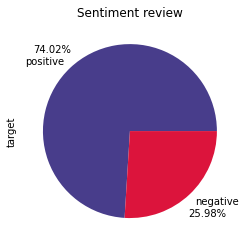

In [ ]:
colors=['darkslateblue', 'crimson']
df['target'].value_counts().plot.pie(autopct='%1.2f%%',pctdistance=1.3, colors=colors)
plt.title('Sentiment review')


In [ ]:
print('Proporcion por cada cada tipo de estrella:')
df.groupby(['stars'])['stars'].count()/df['stars'].count().sum()

Proporcion por cada cada tipo de estrella:


stars
1.0    0.168538
2.0    0.091224
4.0    0.246814
5.0    0.493424
Name: stars, dtype: float64

In [ ]:
weights = [
    {'id':1, 'weight': 0.168538},
    {'id':2, 'weight': 0.091224},
    {'id':4, 'weight': 0.246814},
    {'id':5, 'weight': 0.493424}
]

def getWeight(rate):
    for x in weights:
        if rate == x['id']:
            return x['weight']
        

df['weights'] = df['stars'].apply( lambda x: getWeight(x) )

In [ ]:
df.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id,length,target,weights
0,EhGPj8iJDIdaHnWg9d5BgA,0,2016-04-20 14:30:53,0,uJRdHLz4XNmDK5pOkWbZNA,5.0,"Best Dim Sum in the city, their cart service i...",0.0,POETn3fQcZ8ngLAARCATSg,281,positive,0.493424
1,VPcFNI-6HICR5SJM--KjNA,5,2013-05-14 03:08:12,2,TlPh8jy8bt_TSGfjEw-pvA,5.0,How... HOW did I not head down here sooner? Fo...,7.0,oUK6Xs5dPPnP4whFeZExGg,1546,positive,0.493424
2,ugdUuApH3pYXggW5qpbALg,0,2016-08-26 16:51:37,0,GmoBAVE1pTo0kjmeKrXmLQ,4.0,Carnitas were wonderful. First time there and ...,0.0,SiaSUNlKQK7f57WBPmyyNw,206,positive,0.246814
3,3fCxmmg8nHGaE5upJWQUrw,0,2016-03-24 17:23:19,0,ZHuM9P81zfuNuFZ5ThXNRg,5.0,Great staff who are always willing to help. I ...,0.0,PsH5Qi8R69WAlhNv8mXWRA,275,positive,0.493424
5,wu5nk3pY1e_ou_Le_U52Sw,0,2010-04-20 20:43:49,2,43ps1xif7NwDLEyEsc5LSw,4.0,Sheer coincidence that I'm writing a review fo...,0.0,MAxVtL7aoYbbQav4c3jnlw,184,positive,0.246814


# 4 - Natural Language Processing

Con base en los pesos definiremos un sample.

> Bloque con sangría



In [ ]:
cantidad_muestras = 5000

In [ ]:
sample = df.sample(n=cantidad_muestras, weights='weights', random_state=1)
sample.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id,length,target,weights
1393688,J4CATH00YZrq8Bne2S4_cw,1,2013-01-08 00:41:03,0,mWwpfwSj-Usy0UC3IEiRIw,4.0,bread and the cheese puffs at the beginning we...,0.0,-PXrxfoajGpAOcQsQE6FOw,268,positive,0.246814
2407183,Qbwb8UEm5th5jAO-xIezMw,1,2016-01-21 21:14:53,0,tTgrcMi2vW3JI62KAIBfNg,5.0,"Shad come out and did a great job,very profess...",4.0,3ypqG3bh_KC48kg53pBT-w,142,positive,0.493424
395,5EnHfzuyBf03UhJH4E4mAA,0,2015-08-31 15:57:10,0,ryWnE3koc9D5z2HBUPjq1Q,4.0,We were a group of 8 at Mr. Flamingo last Satu...,1.0,JJYoSUE7xrr5DN5lLWZw7Q,1376,positive,0.246814
1010964,ij_czg0xkJR6xvnQdgnMDA,1,2015-01-20 02:35:50,1,05Hydv6oTJBooZosbw0E0A,4.0,"As the Harris Teeter closest to my house, it h...",3.0,H7JLpACO44A3xVXnOt1Z_A,656,positive,0.246814
490460,plHKBwA18aWeP-TG8DC96Q,0,2018-06-27 20:54:02,0,VfputfsSzZwYSPQ4yfNjgg,5.0,Smoke taqueria is incredible. Their chicken ap...,0.0,VoXnKpUYYpzXLoU74GGhQA,426,positive,0.493424


In [ ]:
df_comments = sample[['stars', 'text', 'target']]
df_comments = df_comments.dropna(subset=['text'])
df_comments = df_comments.reset_index(drop=True)
print(f'Dataset shape: {df_comments.shape}')
df_comments.columns = ['score', 'comment', 'target']
df_comments.head()

Dataset shape: (5000, 3)


,score,comment,target
0,4.0,bread and the cheese puffs at the beginning we...,positive
1,5.0,"Shad come out and did a great job,very profess...",positive
2,4.0,We were a group of 8 at Mr. Flamingo last Satu...,positive
3,4.0,"As the Harris Teeter closest to my house, it h...",positive
4,5.0,Smoke taqueria is incredible. Their chicken ap...,positive


# Text Pre-processing

### Removing non english reviews

Es muy probable que entre los reviews hayan comentários en idiomas diferentes del inglés. Para entrenar nuestro modelo, iremos considerar solo los comentários en inglés, para no prejudicar el redimiento del modelo.

In [ ]:
df_comments['language'] = df_comments['comment'].apply(detect)

In [ ]:
df_comments.head()

,score,comment,target,language
0,4.0,bread and the cheese puffs at the beginning we...,positive,en
1,5.0,"Shad come out and did a great job,very profess...",positive,en
2,4.0,We were a group of 8 at Mr. Flamingo last Satu...,positive,en
3,4.0,"As the Harris Teeter closest to my house, it h...",positive,en
4,5.0,Smoke taqueria is incredible. Their chicken ap...,positive,en


In [ ]:
df_comments['language'].value_counts()

en    4983
fr      16
de       1
Name: language, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



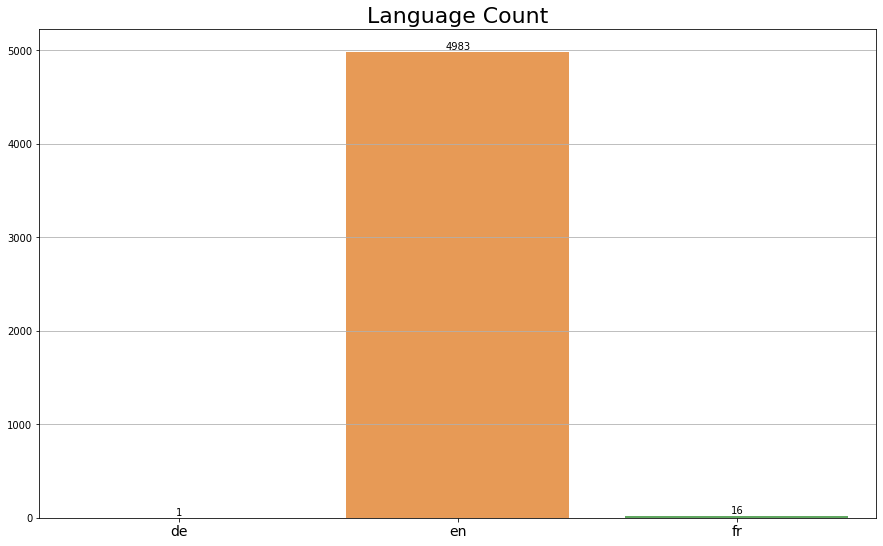

In [ ]:
x=df_comments['language'].value_counts()
x=x.sort_index()
#plot
plt.figure(figsize=(15,9))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Language Count", fontsize = 22)
plt.xlabel('', fontsize=16)
plt.tick_params(axis='x', which='major', labelsize=14)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.grid(axis='y')
plt.show()

In [ ]:
df_comments = df_comments.drop(df_comments[df_comments['language'] != 'en'].index)

In [ ]:
df_comments.reset_index(drop=True, inplace=True)
df_comments['language'].value_counts()


en    4983
Name: language, dtype: int64

In [ ]:
df_nube = df_comments.copy(deep=True)

### Regular Expressions

En esa sección realizamos el processamiento de la columna "comment", donde están los comentários de los clientes para "limpiar" los comentários de links, caracteres especiales, etc. Utilizamos las Regular Expressions para buscar patrones en el texto de los comentários.

In [ ]:
# Función imprimir resultados
def print_results(text_before, text_after, idx_list):
  i = 1
  for idx in idx_list:
    print(f'--- Text {i} ---\n')
    print(f'Before: \n{text_before[idx]}\n')
    print(f'After: \n{text_after[idx]}\n')
    i += 1

# RegEx Quiebra de Línea
def clear_breakline(text_list):
    return [re.sub('[\n\r]', ' ', r) for r in text_list]

# RegEx Links
def clear_hiperlinks(text_list):
    pattern = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    return [re.sub(pattern, ' link ', r) for r in text_list]

# RegEx Números
def clear_numbers(text_list):
    return [re.sub('[0-9]+', ' number ', r) for r in text_list]

# RegEx Dinero
def clear_money(text_list):
    pattern = '[$]'
    return [re.sub(pattern, ' money ', r) for r in text_list]

# RegEx Negacion
def clear_negation(text_list):
    return [re.sub("([nN][oO][tT]|[nN][oO]|[dD][oO][nN][tT]|[dD][oO][nN]['][tT]|[dD][oO][eE][sS][ ][nN][oO][tT]|[dD][oO][eE][sS]['][nN][tT])", ' negation ', r) for r in text_list]

# RegEx Caracteres Especiales
def clear_special_chars(text_list):
    return [re.sub("(['\W']|[_])", ' ', r) for r in text_list]

#  RegEx Espacio en Blanco
def clear_whitespaces(text_list):
    white_spaces = [re.sub('\s+', ' ', r) for r in text_list]
    white_spaces_end = [re.sub('[ \t]+$', '', r) for r in white_spaces]
    return white_spaces_end

# Remover Stopwords
def clear_stopwords(text, cached_stopwords=stopwords.words('english')):
    return [c.lower() for c in text.split() if c.lower() not in cached_stopwords]

# Función Stemming
def stemming_function(text, stemmer=RSLPStemmer()):
    return [stemmer.stem(c) for c in text.split()]

In [ ]:
# Crea lista de palabras
reviews = list(df_comments['comment'].values)

# Aplicar RegEx Quiebra de Línea
reviews_breakline = clear_breakline(reviews)
df_comments['comment'] = reviews_breakline

# Aplicar RegEx Links
reviews_hiperlinks = clear_hiperlinks(reviews_breakline)
df_comments['comment'] = reviews_hiperlinks

# Aplicar RegEx Numeros
reviews_numbers = clear_numbers(reviews_hiperlinks)
df_comments['comment'] = reviews_numbers

# Aplicar RegEx Dinero
reviews_money = clear_money(reviews_numbers)
df_comments['comment'] = reviews_money

# Aplicar RegEx Negacion
reviews_negation = clear_negation(reviews_money)
df_comments['comment'] = reviews_negation

# Aplicar RegEx Caracteres Especiales
reviews_special_chars = clear_special_chars(reviews_negation)
df_comments['comment'] = reviews_special_chars

# Aplicar RegEx Espacio en Blanco
reviews_whitespaces = clear_whitespaces(reviews_special_chars)
df_comments['comment'] = reviews_whitespaces

# Revomer stopwords
reviews_stopwords = [' '.join(clear_stopwords(review)) for review in reviews_whitespaces]
df_comments['comment'] = reviews_stopwords

# Aplicar stemming
reviews_stemmer = [' '.join(stemming_function(review)) for review in reviews_stopwords]
df_comments['comment'] = reviews_stemmer

In [ ]:
# Verificando results
print_results(reviews, reviews_stemmer, idx_list=[427])

--- Text 1 ---

Before: 
I returned to Seoul Hot Pot to try their non-grill menu, and I came away very impressed and questioning my current devotion to Seoul Garden as the top dog in Cleveland Korean cuisine.

Their seafood pancake might be the best I've had thus far, prepared with just the right amount of pancake, scallions, and seafood. Their dukbokki (spicy rice cake) also steals the crown from Seoul Garden, as it packs a much more dynamic, hearty flavor, and they even topped it off with a few strips of savory bulgogi. The rice cakes were so tender they practically melted in my mouth. Their japchae was delicious, not much else to say there. The bibimbap, however, arrived already burnt, our server forgot the chili sauce, and overall it just lacked flavor. Rounding the meal out was the banchan, which was standard fare, and the complimentary orange slices which are still out-of-this-world good.

Where they take the hit this time is their service. The owner manning the tables that night

## Extracción de características - Bag of Words


Necesitamos una forma de representar datos de texto para el algoritmo de aprendizaje automático y el modelo de 'Bag of Words' nos ayuda a lograr esa tarea. En este enfoque, usamos las palabras tokenizadas para cada observación y averiguamos la frecuencia de cada token.

El proceso de convertir texto NLP en números se llama vectorización en ML.

In [ ]:
df_comments.info()
cunt_row = df_comments.shape[0]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4983 entries, 0 to 4982
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   score     4983 non-null   float64
 1   comment   4983 non-null   object 
 2   target    4983 non-null   object 
 3   language  4983 non-null   object 
dtypes: float64(1), object(3)
memory usage: 155.8+ KB


In [ ]:
df_comments.head()

,score,comment,target,language
0,4.0,bread chees puff beginning yummy negation afra...,positive,en
1,5.0,shad com great job profess helpful fast would ...,positive,en
2,4.0,group numb mr flaming last saturday night keep...,positive,en
3,4.0,harril teet closest hous check im far harril t...,positive,en
4,5.0,smok taqu incredibl chicken appl tac negation ...,positive,en


In [ ]:
# Unigramas
unigrams_vectorizer = CountVectorizer(token_pattern='(?u)\\b\\w+\\b')
unigrams = unigrams_vectorizer.fit_transform(df_comments['comment'].values.astype('U'))
unigrams_df = pd.DataFrame(unigrams.todense(), columns=unigrams_vectorizer.get_feature_names())
unigrams_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4983 entries, 0 to 4982
Columns: 14644 entries, aa to übe
dtypes: int64(14644)
memory usage: 556.7 MB


In [ ]:
# Bigramas
#bigrams_vectorizer = CountVectorizer(ngram_range=(2,2), token_pattern='(?u)\\b\\w+\\b')
#bigrams = bigrams_vectorizer.fit_transform(df_comments['comment'].values.astype('U'))
#bigrams_df = pd.DataFrame(bigrams.todense(), columns=bigrams_vectorizer.get_feature_names())
#bigrams_df.info()

In [ ]:
  # Trigramas
#trigrams_vectorizer = CountVectorizer(ngram_range=(3,3), token_pattern='(?u)\\b\\w+\\b')
#trigrams = trigrams_vectorizer.fit_transform(df_comments['comment'].values.astype('U'))
#trigrams_df = pd.DataFrame(trigrams.todense(), columns=trigrams_vectorizer.get_feature_names())
#trigrams_df.info()

In [ ]:
# Mergeamos los ngramas_df con df_comments
df_comments = pd.concat([df_comments, unigrams_df], axis=1)
#df_comments = pd.concat([df_comments, bigrams_df], axis=1)
#df_comments = pd.concat([df_comments, trigrams_df], axis=1)
df_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4983 entries, 0 to 4982
Columns: 14648 entries, score to übe
dtypes: float64(1), int64(14644), object(3)
memory usage: 556.9+ MB


In [ ]:
df_comments.head()

,score,comment,target,language,aa,aaa,aangan,aardvark,aaron,ab,abalon,abandoned,abay,abbey,abbit,abbreviated,abby,abc,abdom,abdomen,abdul,abead,abeul,abiding,ability,abl,ably,abr,abroad,abrupt,abruptly,absenc,absolut,absolutely,absolutley,absoluty,absorb,absorbed,abuel,abundanc,...,zapat,zapp,zar,zatt,zberri,zeal,zealand,zek,zen,zep,zepool,zeppol,zer,zereshk,zeroing,zeu,zhou,zillion,zin,zinburg,zing,zion,zip,ziplining,zipp,zippy,znnemnz,zogoflex,zombi,zon,zoned,zoning,zoo,zucchin,zuchinn,zupp,zuzu,¼,à,übe
0,4.0,bread chees puff beginning yummy negation afra...,positive,en,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,5.0,shad com great job profess helpful fast would ...,positive,en,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4.0,group numb mr flaming last saturday night keep...,positive,en,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4.0,harril teet closest hous check im far harril t...,positive,en,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5.0,smok taqu incredibl chicken appl tac negation ...,positive,en,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Sentiment Analysis



In [ ]:
df_comments = df_comments.loc[:, ~df_comments.columns.duplicated()]
df_comments['target']

0       positive
1       positive
2       positive
3       positive
4       positive
          ...   
4978    positive
4979    positive
4980    positive
4981    negative
4982    positive
Name: target, Length: 4983, dtype: object

In [ ]:
X = df_comments.drop(columns=['score', 'comment', 'language','target'])
X.head()

,aa,aaa,aangan,aardvark,aaron,ab,abalon,abandoned,abay,abbey,abbit,abbreviated,abby,abc,abdom,abdomen,abdul,abead,abeul,abiding,ability,abl,ably,abr,abroad,abrupt,abruptly,absenc,absolut,absolutely,absolutley,absoluty,absorb,absorbed,abuel,abundanc,abundant,abus,abused,abusiv,...,zapat,zapp,zar,zatt,zberri,zeal,zealand,zek,zen,zep,zepool,zeppol,zer,zereshk,zeroing,zeu,zhou,zillion,zin,zinburg,zing,zion,zip,ziplining,zipp,zippy,znnemnz,zogoflex,zombi,zon,zoned,zoning,zoo,zucchin,zuchinn,zupp,zuzu,¼,à,übe
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
y = df_comments['target'].apply(lambda x: 1 if x == 'positive' else 0).values

In [ ]:
X.shape

(4983, 14642)

In [ ]:
y.shape

(4983,)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=42)


In [ ]:

logistic = LogisticRegression()

# Specifing a Logistic Regression model for sentiment classification
logreg_param_grid = {
    'C': np.linspace(0.1, 10, 20),
    'penalty': ['l1', 'l2'],
    'class_weight': ['balanced', None],
    'random_state': [42],
    'solver': ['liblinear']
}

# Setting up the classifiers
set_classifiers = {
    'LogisticRegression': {
        'model': LogisticRegression(),
        'params': logreg_param_grid
    }
}

In [ ]:
clf = RandomizedSearchCV(logistic, logreg_param_grid, random_state=1, n_iter=80, cv=5, verbose=0, n_jobs=-1)

In [ ]:
best_model = clf.fit(X, y)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



In [ ]:
print('Mejor Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Mejor C:', best_model.best_estimator_.get_params()['C'])
print('Mejor Class-weight:', best_model.best_estimator_.get_params()['class_weight'])

Mejor Penalty: l2
Mejor C: 1.142105263157895
Mejor Class-weight: None


In [ ]:
logreg = LogisticRegression(C = 1.66, penalty = 'l2', class_weight = 'balanced', random_state = 42, solver='liblinear')
logreg.fit(X_train, y_train)

LogisticRegression(C=1.66, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
log_preds = logreg.predict(X_test)

In [ ]:
print(classification_report(y_test,log_preds))

              precision    recall  f1-score   support

           0       0.78      0.76      0.77       171
           1       0.97      0.97      0.97      1324

    accuracy                           0.95      1495
   macro avg       0.87      0.87      0.87      1495
weighted avg       0.95      0.95      0.95      1495



In [ ]:
def sentiment_analisys(texto):
  texto = clear_breakline(texto)
  texto = clear_hiperlinks(texto)
  texto = clear_numbers(texto)
  texto = clear_money(texto)
  texto = clear_negation(texto)
  texto = clear_special_chars(texto)
  texto = clear_whitespaces(texto)
  texto = [' '.join(clear_stopwords(txt)) for txt in texto]
  texto = [' '.join(stemming_function(txt)) for txt in texto]

  prueba_unigrams_vectorizer = CountVectorizer(token_pattern='(?u)\\b\\w+\\b')
  prueba_unigrams = prueba_unigrams_vectorizer.fit_transform(texto)
  prueba_unigrams_df = pd.DataFrame(prueba_unigrams.todense(), columns=prueba_unigrams_vectorizer.get_feature_names())

  dic_prueba = {}

  for x in X.columns:
    if x in prueba_unigrams_df.columns:
      dic_prueba[x] = 1
    else:
      dic_prueba[x] = 0

  prueba_df = pd.DataFrame(dic_prueba, index = [0])

  pred = logreg.predict(prueba_df)
  proba = logreg.predict_proba(prueba_df)

  fig, ax = plt.subplots(figsize=(5, 3))
  if pred[0] == 1:
    text = 'Positivo'
    class_proba = 100 * round(proba[0][1], 2)
    color = 'white'
  else:
    text = 'Negativo'
    class_proba = 100 * round(proba[0][0], 2)
    color = 'grey'
  ax.text(0.5, 0.5, text, fontsize=50, ha='center', color=color)
  ax.text(0.5, 0.20, str(class_proba) + '%', fontsize=14, ha='center')
  ax.axis('off')
  ax.set_facecolor('m')
  ax.set_title('Sentiment Analysis', fontsize=14)
  plt.show()

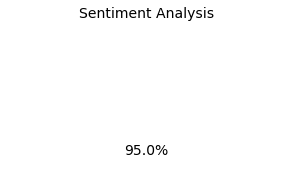

In [ ]:
#Probando un texto cualquiera

#texto = ["The worst seller! Very slow shipping"]
texto = ["Excellent seller! Fast responds"]
sentiment_analisys(texto)

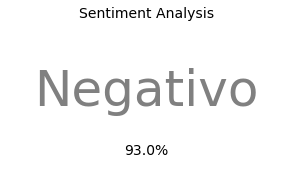

In [ ]:
texto = ["The worst seller! Very slow shipping"]
#texto = ["Excellent seller! Fast responds"]
sentiment_analisys(texto)

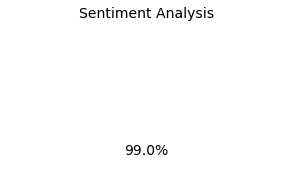

In [ ]:
texto = ["Very nice breakfast place. Food was good. Presentation could be a little more creative, but other than that, I would eat here again. Service was good as well."]
sentiment_analisys(texto)

###NUBE DE PALABRAS

In [ ]:
nube_stopwords = [' '.join(clear_stopwords(review)) for review in list(df_nube['comment'].values)]
df_nube['stopwords_removed'] = nube_stopwords

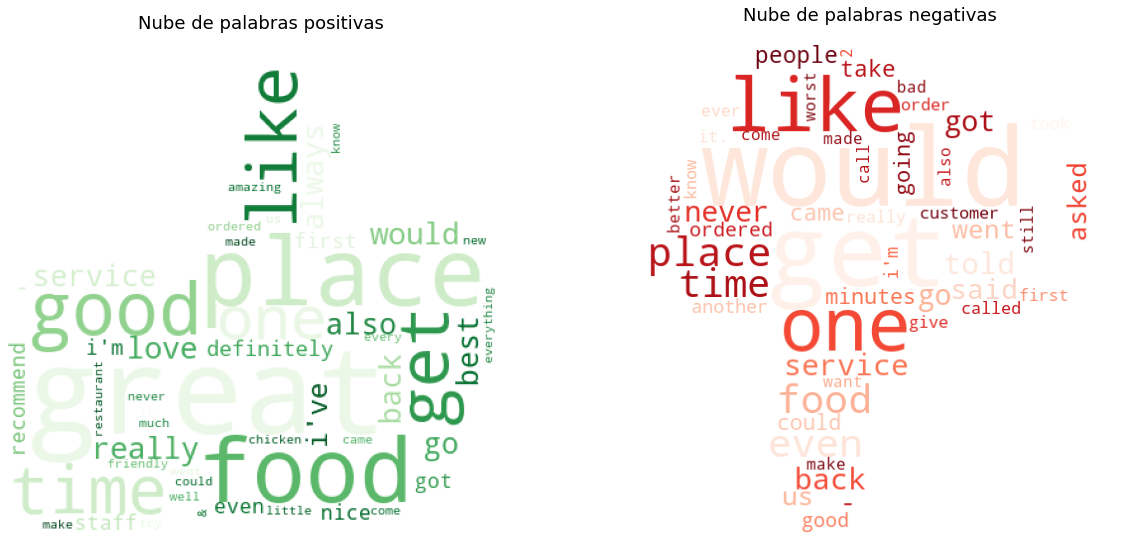

In [ ]:
#Lectura de la mascara a aplicar
like_mask = np.array(Image.open("/content/drive/MyDrive/images/like.png"))
bomb_mask = np.array(Image.open("/content/drive/MyDrive/images/notLike.png"))
#angry_mask = angry_mask[:, :, -1]

#aplicando mascara
transf_like_mask = np.ndarray((like_mask.shape[0], like_mask.shape[1]), np.int32)
for i in range(len(like_mask)):
    transf_like_mask[i] = [255 if px == 0 else 0 for px in like_mask[i]]

# Transforming angry mask
transf_notlike_mask = np.ndarray((bomb_mask.shape[0], bomb_mask.shape[1]), np.int32)
for i in range(len(bomb_mask)):
    transf_notlike_mask[i] = [255 if px == 0 else 0 for px in bomb_mask[i]]
    
# Generating words
pos_comments = list(df_nube.query('target == "positive"')['stopwords_removed'].values)
positive_words = ' '.join(pos_comments).split(' ')
neg_comments = list(df_nube.query('target == "negative"')['stopwords_removed'].values)
negative_words = ' '.join(neg_comments).split(' ')

# Using Counter for creating a dictionary counting
positive_dict = Counter(positive_words)
negative_dict = Counter(negative_words)

# Generating wordclouds for both positive and negative comments
positive_wc = WordCloud(width=1280, height=720, collocations=False, random_state=42, mask=transf_like_mask,
                      colormap='Greens', background_color='white', max_words=50).generate_from_frequencies(positive_dict)
negative_wc = WordCloud(width=1280, height=720, collocations=False, random_state=42, mask=transf_notlike_mask,
                      colormap='Reds', background_color='white', max_words=50).generate_from_frequencies(negative_dict)

# Visualizing the WC created and the total for each cuisine
fig, axs = plt.subplots(1, 2, figsize=(20, 20))
ax1 = axs[0]
ax2 = axs[1]

ax1.imshow(positive_wc)
ax1.axis('off')
ax1.set_title('Nube de palabras positivas', size=18, pad=20)

ax2.imshow(negative_wc)
ax2.axis('off')
ax2.set_title('Nube de palabras negativas', size=18, pad=20)

plt.show()